In [7]:
"""
Text Analytics using NLP for analysis of Citation Listing

Also some example code for graphing nodes & edge data

Recommended dataset by Professor Zhang
DBLP collaboration network and ground-truth communities
-------------------------------------------------------
- https://snap.stanford.edu/data/com-DBLP.html
  data/com-dblp.ungraph.txt
  data/com-dblp.all.cmty.txt
  
Movie recommender tutorial - with some NLP analytics  
https://www.datacamp.com/community/tutorials/recommender-systems-python  
"""
#!pip3 install snap-stanford
#!pip3 install wordcloud

'\nText Analytics using NLP for analysis of Citation Listing\n\nAlso some example code for graphing nodes & edge data\n\nRecommended dataset by Professor Zhang\nDBLP collaboration network and ground-truth communities\n-------------------------------------------------------\n- https://snap.stanford.edu/data/com-DBLP.html\n  data/com-dblp.ungraph.txt\n  data/com-dblp.all.cmty.txt\n  \nMovie recommender tutorial - with some NLP analytics  \nhttps://www.datacamp.com/community/tutorials/recommender-systems-python  \n'

In [12]:
# Load pandas
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import StandardScaler, Normalizer, normalize

# regular expression package for removing punctuation from text
import re

# which folders host all the python files
import sys

In [14]:
# Since path is a list, you can use the append method to add new directories to the path
# !ls '/Users/paipac/.local/lib/python3.7/site-packages'
# sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")
# print(sys.path)

In [15]:
#%cd '~/Projects/big_data_eng/bde_lab_2'
#%ls

In [16]:
#reading graph data downloaded from https://snap.stanford.edu/data/com-DBLP.html 
#data = pd.read_table('data/com-dblp.ungraph.txt', header=3)
#data.head(5)
#print(data.info())

#data.columns = ['FromNodeId','ToNodeId']
#print(data.describe())

In [17]:
# saving code preparing graph data from snap.stanford.edu
def data_edges_nodes():
    df_edges = data.copy()
    print('len df_edges:',len(df_edges))
    df_edges = df_edges[df_edges['FromNodeId']<=500]
    print('len df_edges:',len(df_edges))
    df_edges = df_edges[df_edges['ToNodeId']<=500]
    print('len df_edges:',len(df_edges))
    
    df_nodes = df_edges['FromNodeId'].value_counts().reset_index().rename(columns={'index':'Node','FromNodeId':'Count'}).sort_values('Node',ascending=True)
    print('df_nodes.head()',df_nodes.head(5))
    print('df_nodes.tail()',df_nodes.tail(5))
    
    df_weight = df_edges[['ToNodeId']].copy()
    #df_weight = df_weight.groupby('ToNodeId').count().reset_index()
    df_weight = df_weight['ToNodeId'].value_counts().reset_index().sort_values('ToNodeId',ascending=True)
    df_weight.columns = ['ToNodeId','Weight']
    df_weight
    
    df_edges = pd.merge(df_edges, df_weight, on='ToNodeId')
    print('df_edges.head()',df_edges.head(5)
      
    # save node & edge graph data 
    df_nodes.to_csv('data/test_nodes.csv', index=False)
    df_edges.to_csv('data/test_edges.csv', index=False)

SyntaxError: invalid syntax (<ipython-input-17-ee645efde7c3>, line 24)

In [18]:
# saving code related to graphing data from snap.stanford.edu
def data_graph_show():
    G = nx.Graph()  

    # dict keys must match node "id" label
    color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
                 7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
                 13:'#d6dcff', 14:'#d2f5f0'}       

    # create graph nodes & weighted edges
    i=0
    for index, row in df_nodes.iterrows():
        #G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
        G.add_node(row['Node'], nodesize=row['Count'])
        i=i+1

    for index, row in df_edges.iterrows():
        #G.add_weighted_edges_from([(row['source'], row['target'], row['value'])])
        G.add_weighted_edges_from([(row['FromNodeId'], row['ToNodeId'], row['Weight'])])

    print('node rows:',i)

    # color_map = {'reviewer':'#f09494', 'listing':'#eebcbc' }

    plt.figure(figsize=(6,6))
    options = {
        'edge_color': '#FFDEA2',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }

    #set colours for nodes
    #colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]
    sizes = [G.nodes[n]['nodesize']*1 if len(G.nodes[n].keys())>0 else 1 for n in G]

    """
    Using the spring layout : 
    - k controls the distance between the nodes and varies between 0 and 1
    - iterations is the number of times simulated annealing is run
    - default k=0.1 and iterations=50

    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
    """
    nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=0.5, iterations=50), **options)
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555") 
    plt.show();
    

## Simple recommender systems - top N items based on a certain metric or score

Based on tutorial # https://www.datacamp.com/community/tutorials/recommender-systems-python

In [23]:
# Load in the Citations data
doc_dv = '../csv-files/Citations_DV_Aust_Google.csv'
data = pd.read_csv(doc_dv)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Publication ID                                           2500 non-null   object
 1   DOI                                                      2500 non-null   object
 2   Title                                                    2500 non-null   object
 3   Abstract                                                 655 non-null    object
 4   Source title/Anthology title                             2225 non-null   object
 5   PubYear                                                  2500 non-null   int64 
 6   Authors                                                  1960 non-null   object
 7   Authors Affiliations - Name of Research organization     1035 non-null   object
 8   Authors Affiliations - Country of Rese

In [24]:
# Extract only the useful dimensions
df_cit_dv = data[['Title','Abstract','Authors','Authors Affiliations - Name of Research organization','Times cited']].copy()
df_cit_dv.columns = ['Title','Abstract','Authors','Authors Affiliations','Times Cited']
df_cit_dv.head(3)

,Title,Abstract,Authors,Authors Affiliations,Times Cited
0,Sustainable fashion: current and future resear...,Purpose The sustainable fa...,"Mukendi, Amira; Davies, Iain; Glozer, Sarah; M...",University of Bath,7
1,The (Neglected) role of the father in Children...,Background Although the bulk of the literature...,"Louca, Eleonora Papaleontiou -; Omari, Omar Al",European University Cyprus; Sultan Qaboos Univ...,0
2,Literary Translation in Periodicals,"While translation history, literary translatio...",NaN,NaN,0


In [26]:
# remove any where Citation counts = 0
df_cit_dv = df_cit_dv[df_cit_dv['Times Cited']>0]

df_cit_dv.to_csv('../csv-files/Citations_DV_Aust_Google_small.csv')
df_cit_dv.shape

(124, 5)

In [22]:
# Calculate mean of Times Cited
C = df_cit_dv['Times Cited'].mean()
print(C)

2.314516129032258


In [201]:
# Calculate the minimum number of citations required to be in the chart, m
m = df_cit_dv['Times Cited'].quantile(0.90)
print(m)

4.0


In [204]:
# Filter out all qualified papers into a new DataFrame
q_cit_dv = df_cit_dv.copy().loc[df_cit_dv['Times Cited'] >= m] 
q_cit_dv.shape

(18, 5)

In [206]:
# Function that computes the weighted rating of each paper
def weighted_rating(x, m=m, C=C):
    v = x['Times Cited']
    R = x['Times Cited']
    # Calculation based on the IMDB formula
    # return (v/(v+m) * R) + (m/(m+v) * C)
    return v

# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_cit_dv['score'] = q_cit_dv.apply(weighted_rating, axis=1)

In [207]:
#Sort movies based on score calculated above
q_cit_dv = q_cit_dv.sort_values('score', ascending=False)

#Print the top 15 movies
q_cit_dv[['Title','Authors','Authors Affiliations','Times Cited']].head(10)

,Title,Authors,Authors Affiliations,Times Cited
962,ESO-WSO 2020 Joint Meeting Abstracts,NaN,NaN,26
1414,"Asymptomatic Transmission, the Achilles’ Heel ...","Gandhi, Monica; Yokoe, Deborah S; Havlir, Dian...",NaN,19
1366,The 2020 report of The Lancet Countdown on hea...,"Watts, Nick; Amann, Markus; Arnell, Nigel; Aye...",University College London; International Insti...,18
1659,Antecedents and consequences of problematic sm...,"Busch, Peter André; McCarthy, Stephen",University of Agder; University College Cork,12
948,Interventions to support the resilience and me...,"Pollock, Alex; Campbell, Pauline; Cheyne, Josh...",Glasgow Caledonian University; University of E...,10
1427,Strong Social Distancing Measures in the Unite...,"Courtemanche, Charles; Garuccio, Joseph; Le, A...",NaN,10
0,Sustainable fashion: current and future resear...,"Mukendi, Amira; Davies, Iain; Glozer, Sarah; M...",University of Bath,7
1596,ESICM LIVES 2020,NaN,NaN,7
926,"Psychological distress, anxiety, family violen...","Every-Palmer, Susanna; Jenkins, Matthew; Genda...",University of Otago,7
24,Sociotechnical agendas: Reviewing future direc...,"Sovacool, Benjamin K.; Hess, David J.; Amir, S...",University of Sussex; Aarhus University; Vande...,7


## Content-Based Recommender
A system that recommends papers that are similar to a particular paper. To achieve this, we compute pairwise cosine similarity scores for all papers based on their Title descriptions and recommend papers based on that similarity score threshold.

Natural Language Processing - you need to extract some kind of features from the above text data before you can compute the similarity and/or dissimilarity between them. It is not possible to compute the similarity between descriptions in their raw forms. We need to compute the word vectors of each description (aka, document).

Word vectors are vectorized representation of words in a document. The vectors carry a semantic meaning with it. For example, man & king will have vector representations close to each other while man & woman would have representation far from each other.

In [220]:
# compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. 
# This will give you a matrix where each column represents a word in the overview vocabulary 
# (all the words that appear in at least one document), and each column represents a paper

#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df_cit_dv['Title'] = df_cit_dv['Title'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_cit_dv['Title'])

#Output the shape of tfidf_matrix - observe that 594 different vocabularies or words in your dataset have 124 papers
tfidf_matrix.shape

(124, 594)

In [221]:
# Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[500:510]

['space',
 'spaces',
 'speeches',
 'spread',
 'squids',
 'stakeholder',
 'state',
 'states',
 'stem',
 'stories']

<b>Compute a similarity score</b>- using the cosine similarity to calculate a numeric quantity that denotes the similarity between two papers. The cosine similarity score is independent of magnitude and is relatively easy and fast to calculate (especially when used in conjunction with TF-IDF scores

In [222]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [223]:
cosine_sim.shape

(124, 124)

In [225]:
cosine_sim[1]

array([0.        , 1.        , 0.11066863, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, you need a reverse mapping of movie titles and DataFrame indices. In other words, you need a mechanism to identify the index of a movie in your metadata DataFrame, given its title.

In [226]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df_cit_dv.index, index=df_cit_dv['Title']).drop_duplicates()

In [228]:
indices[:5]

Title
Sustainable fashion: current and future research directions                                                                0
Meaning, Life and Culture: In conversation with Anna Wierzbicka                                                            9
Is farming a belief in Northern Ghana? Exploring the dual-system theory for commerce, culture, religion and technology    22
How safety affects destination image projected through online travel reviews                                              23
Sociotechnical agendas: Reviewing future directions for energy and climate research                                       24
dtype: int64

You are now in good shape to define your recommendation function. These are the following steps you'll follow:

Get the index of the movie given its title.

Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position, and the second is the similarity score.

Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.

Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).

Return the titles corresponding to the indices of the top elements.

In [229]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_cit_dv['Title'].iloc[movie_indices]

In [236]:
df_recommend = get_recommendations('Sustainable fashion: current and future research directions')
df_recommend.to_csv('Recommend Papers.csv')

In [285]:
list_title = df_cit_dv[['Title']].copy()
list_title = list_title.astype(str).values.tolist()

list_title = ",".join([str(x) for x in list_title])

#chars = re.escape(string.punctuation)
#chars = '!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'
chars = '!"\\“”‘’–\\#\\$%\\&\'\\(\\)\\*\\+£®\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'

text = re.sub(r'['+chars+']', '', list_title)

print(text) #.strip('[]')

Sustainable fashion current and future research directions,Meaning, Life and Culture In conversation with Anna Wierzbicka,Is farming a belief in Northern Ghana Exploring the dualsystem theory for commerce, culture, religion and technology,How safety affects destination image projected through online travel reviews,Sociotechnical agendas Reviewing future directions for energy and climate research,Vampire squids, the broken internet and platform regulation,The politics of gendered space Social norms and purdah affecting female informal work in Dhaka, Bangladesh,Handbook of Risk and Crisis Communication,Risk Communication Education for Local Emergency Managers Using the CAUSE Model for Research, Education, and Outreach,PostCrisis Communication and Renewal Understanding the Potential for Positive Outcomes in Crisis Communication,The Significance of Crisis and Risk Communication,Virtual Risk The Role of New Media in Violent and Nonviolent Ideological Groups,Community Building through Risk C

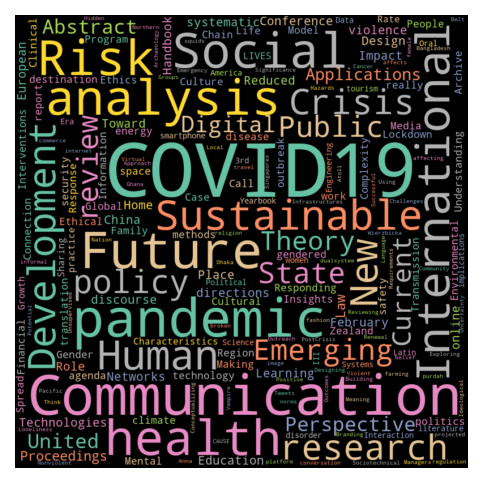

In [286]:
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Create and generate a word cloud image:   
wordcloud = WordCloud(width = 800, height = 800, random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS).generate(text)

# Display the generated image:
# import matplotlib.pylab as plt
# plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()